In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from ast import literal_eval
import numpy as np

from utilities import convert_to_2022_dollars, get_tract_spending, add_overlapping_tif, get_thirds

In [2]:
tracts2000 = gpd.read_file("../data/chicago_tracts_2000.geojson").to_crs("EPSG:26916")
tracts2010 = gpd.read_file("../data/chicago_tracts_2010.geojson").to_crs("EPSG:26916")
illinois1990 = gpd.read_file("../data/illinois_tracts_1990.json").to_crs("EPSG:26916")
illinois2020 = gpd.read_file("../data/illinois_tracts_2020.json").to_crs("EPSG:26916")
chicagoborder = gpd.read_file("../data/chicago_border.geojson").to_crs("EPSG:26916")
tif_2022 = gpd.read_file("../data/tif_districts_2022.geojson").to_crs("EPSG:26916")
tif_2013 = gpd.read_file("../data/tif_districts_2013_2.json").to_crs("EPSG:26916")
projects = pd.read_csv("../data/tif_projects.csv")

In [3]:
# Combine tif districts geodataframes
for col in tif_2022.columns.tolist():
    rename_dict = {}
    if col != 'geometry':
        rename_dict[col] = col.upper()
    tif_2022.rename(inplace=True, columns=rename_dict)
    
tif = pd.concat([tif_2013, tif_2022], ignore_index=True)
tif.drop_duplicates(inplace=True, subset="NAME")
tif['APPROVAL_YEAR'] = pd.to_datetime(tif['APPROVAL_D']).dt.year
tif["EXPIRATION_YEAR"] = pd.to_datetime(tif["EXPIRATION"]).dt.year

In [4]:
# Get only census tracts inside chicago city
tracts1990 = illinois1990.sjoin(chicagoborder)
tracts2000 = tracts2000.sjoin(chicagoborder)
tracts2010 = tracts2010.sjoin(chicagoborder)
tracts2020 = illinois2020.sjoin(chicagoborder)

In [5]:
# Get GEO_ID for 1990
tracts1990.loc[tracts1990['TRACTSUF'] == "", "TRACTSUF"] = "00"
tracts1990['GEO_ID'] = tracts1990['ST'].astype(str) + tracts1990['CO'].astype(str) \
+ tracts1990['TRACTBASE'].astype(str) + tracts1990['TRACTSUF'].astype(str)

In [6]:
# Get GEO_ID for other decades
tracts2000['GEO_ID'] = tracts2000['census_t_1']
tracts2010['GEO_ID'] = tracts2010['geoid10']
tracts2020['GEO_ID'] = tracts2020['GEOID']

In [7]:
# Add white proportion
race2020 = pd.read_csv("../data/race2020.csv", skiprows=[1], usecols=["GEO_ID", "P2_001N", "P2_005N"])
race2020.rename(inplace=True, columns={"P2_001N": 'TOTAL', "P2_005N": 'WHITE'})
race2020['WHITE_PROPORTION'] = race2020['WHITE'] / race2020['TOTAL']

race2010 = pd.read_csv("../data/race2010.csv", skiprows=[1], usecols=["GEO_ID", "P002001", "P002005"], dtype={"P002001": int, "P002005": int})
race2010.rename(inplace=True, columns={"P002001": 'TOTAL', "P002005": 'WHITE'})
race2010['WHITE_PROPORTION'] = race2010['WHITE'] / race2010['TOTAL']

race2000 = pd.read_csv("../data/race2000.csv", skiprows=[1], usecols=['GEO_ID', 'PL002001', 'PL002005'])
race2000.rename(inplace=True, columns={"PL002001": 'TOTAL', "PL002005": 'WHITE'})
race2000['WHITE_PROPORTION'] = race2000['WHITE'] / race2000['TOTAL']

race1990 = pd.read_csv("../data/1990.csv", usecols=['BLOCKGR', 'SUMLEV', 'P0010001', 'P0120001'])
race1990.rename(inplace=True, columns={'P0010001': 'TOTAL', 'P0120001': 'WHITE'})
race1990 = race1990.loc[race1990['SUMLEV'] == 140]
race1990['WHITE_PROPORTION'] = race1990['WHITE'] / race1990['TOTAL']
race1990['GEO_ID'] = race1990['BLOCKGR'].str.replace(".", "").str.replace(":", "")

/var/folders/w2/999xw7715kj3_sqxrf0t3nb00000gn/T/ipykernel_98808/2867243339.py:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  race1990['GEO_ID'] = race1990['BLOCKGR'].str.replace(".", "").str.replace(":", "")


In [8]:
# Join race to tracts
for df in [race2000, race2010, race2020]:
    df['GEO_ID'] = df['GEO_ID'].str[-11:]
    
tracts1990 = tracts1990.merge(race1990, on="GEO_ID", how="left")
tracts2000 = tracts2000.merge(race2000, on="GEO_ID", how="left")
tracts2010 = tracts2010.merge(race2010, on="GEO_ID", how="left")
tracts2020 = tracts2020.merge(race2020, on="GEO_ID", how="left")

<AxesSubplot:>

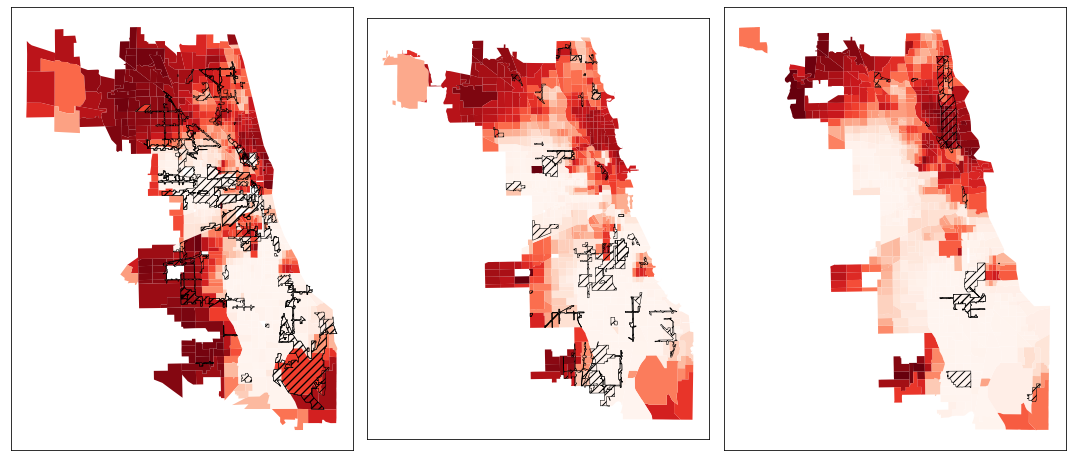

In [9]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15,8), layout="tight")

for ax in [ax1, ax2, ax3]:
    ax.set_xticks([])
    ax.set_yticks([])

tracts1990.plot(ax=ax1, column='WHITE_PROPORTION', cmap="Reds")
tif.loc[(tif['APPROVAL_YEAR'] <= 2000)&(tif['APPROVAL_YEAR'] > 1990)].boundary.plot(ax=ax1, edgecolor="black", linewidth=0.5, hatch="///")
tracts2000.plot(ax=ax2, column='WHITE_PROPORTION', cmap="Reds")
tif.loc[(tif['APPROVAL_YEAR'] <= 2010)&(tif['APPROVAL_YEAR'] > 2000)].boundary.plot(ax=ax2, edgecolor="black", linewidth=0.5, hatch="///")
tracts2010.plot(ax=ax3, column='WHITE_PROPORTION', cmap="Reds")
tif.loc[(tif['APPROVAL_YEAR'] <= 2020)&(tif['APPROVAL_YEAR'] > 2010)].boundary.plot(ax=ax3, edgecolor="black", linewidth=0.5, hatch="///")

In [10]:
# Turn projects into geodataframe
projects = gpd.GeoDataFrame(projects, geometry=gpd.points_from_xy(projects['LONGITUDE'], projects['LATITUDE']))
projects = projects.loc[projects['geometry'].notnull()]
projects = projects.set_crs('EPSG:4326').to_crs("EPSG:26916")
projects['APPROVAL_YEAR'] = pd.to_datetime(projects['CDC DATE']).dt.year

/usr/local/lib/python3.9/site-packages/geopandas/geoseries.py:749: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


In [11]:
# Convert to 2022 dollars
tifspending2022 = projects.apply(lambda x : convert_to_2022_dollars(x['APPROVAL_YEAR'], x['APPROVED AMOUNT']), axis=1)
projects['APPROVED AMOUNT 2022'] = tifspending2022

In [12]:
# Divide projects by approval year
projects1990 = projects.loc[(projects['APPROVAL_YEAR'] >= 1990)&(projects['APPROVAL_YEAR'] < 2000)]
projects2000 = projects.loc[(projects['APPROVAL_YEAR'] >= 2000)&(projects['APPROVAL_YEAR'] < 2010)]
projects2010 = projects.loc[(projects['APPROVAL_YEAR'] >= 2010)&(projects['APPROVAL_YEAR'] < 2020)]
projects2020 = projects.loc[(projects['APPROVAL_YEAR'] >= 2020)]

In [13]:
tracts1990.drop(inplace=True, columns="index_right")
tracts2000.drop(inplace=True, columns="index_right")
tracts2010.drop(inplace=True, columns="index_right")
tracts2020.drop(inplace=True, columns="index_right")

projects1990 = projects1990.sjoin(tracts1990)
projects2000 = projects2000.sjoin(tracts2000)
projects2010 = projects2010.sjoin(tracts2010)
projects2020 = projects2020.sjoin(tracts2020)

In [14]:
tracts1990 = get_tract_spending(tracts1990, projects1990)
tracts2000 = get_tract_spending(tracts2000, projects2000)
tracts2010 = get_tract_spending(tracts2010, projects2010)
tracts2020 = get_tract_spending(tracts2020, projects2020)

/usr/local/lib/python3.9/site-packages/geopandas/geodataframe.py:1499: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  result = DataFrame.merge(self, *args, **kwargs)
/usr/local/lib/python3.9/site-packages/geopandas/geodataframe.py:1499: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  result = DataFrame.merge(self, *args, **kwargs)
/usr/local/lib/python3.9/site-packages/geopandas/geodataframe.py:1499: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  result = DataFrame.merge(self, *args, **kwargs)
/usr/local/lib/python3.9/site-packages/geopandas/geodataframe.py:1499: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right

In [15]:
tracts1990 = add_overlapping_tif(tracts1990, tif, 1990)
tracts2000 = add_overlapping_tif(tracts2000, tif, 2000)
tracts2010 = add_overlapping_tif(tracts2010, tif, 2010)

In [16]:
income2010 = pd.read_csv("../data/mean_income2010.csv", skiprows=[1], usecols=['GEO_ID', 'S1902_C02_001E'])
income2020 = pd.read_csv("../data/mean_income2020.csv", skiprows=[1], usecols=['GEO_ID', 'S1902_C03_001E'])

In [17]:
income2010.rename(inplace=True, columns={"S1902_C02_001E": "MEAN_INCOME_2010"})
income2020.rename(inplace=True, columns={"S1902_C03_001E": "MEAN_INCOME_2020"})

In [18]:
income2010['GEO_ID'] = income2010['GEO_ID'].str[-11:]
income2020['GEO_ID'] = income2010['GEO_ID'].str[-11:]

In [19]:
income2010['MEAN_INCOME_2010'] = income2010['MEAN_INCOME_2010'].str.replace("-", '0')
income2010['MEAN_INCOME_2010'] = income2010['MEAN_INCOME_2010'].astype(float)

In [20]:
income2020['MEAN_INCOME_2020'] = income2020['MEAN_INCOME_2020'].str.replace("-", '0')
income2020['MEAN_INCOME_2020'] = income2020['MEAN_INCOME_2020'].astype(float)

In [21]:
chi_income2010 = 68646
chi_income2020 = 94733

In [22]:
income2010['INCOME_PCT_2010'] = income2010['MEAN_INCOME_2010'] / chi_income2010
income2020['INCOME_PCT_2020'] = income2020['MEAN_INCOME_2020'] / chi_income2020

In [23]:
tracts2010 = tracts2010.merge(income2010, how="left", on="GEO_ID")

In [24]:
tracts2010 = tracts2010.merge(income2020, how="left", on="GEO_ID")

In [25]:
tracts2010['CANDIDATE'] = tracts2010['INCOME_PCT_2010'] <= .7

In [26]:
tracts2010['GENTRIFIED'] = ((tracts2010['CANDIDATE']) & (tracts2010['INCOME_PCT_2020'] - tracts2010['INCOME_PCT_2010'] >= .1))

In [27]:
get_thirds(tracts1990)
get_thirds(tracts2000)
get_thirds(tracts2010)
get_thirds(tracts2020)

In [30]:
tracts1990.to_file("../data/tracts1990.geojson", driver="GeoJSON")
tracts2000.to_file("../data/tracts2000.geojson", driver="GeoJSON")
tracts2010.to_file("../data/tracts2010.geojson", driver="GeoJSON")
tracts2020.to_file("../data/tracts2020.geojson", driver="GeoJSON")

In [31]:
tif.to_file("../data/tif.geojson", driver="GeoJSON")